# Looking at Average CTCF binding around the TSS of DEGs following depletion of Wapl

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import bbi

In [16]:
import gffutils
import pybedtools
from pybedtools.featurefuncs import TSS
from gffutils.helpers import asinterval
import bioframe as bf
from gtfparse import read_gtf

In [3]:
# data needed from experimental set-up to compare 
proj = "/project/fudenber_735/GEO/liu_deWit_2021_GSE135180/pysradb_downloads/SRP216929/"

# s2c to collapse tpm into averages
s2c = pd.read_csv(proj+"s2c.tsv", index_col = 0, sep='\t')

# t2g to compare gene-level analysis
t2g = pd.read_csv("/project/fudenber_735/genomes/mm10/ensembl/ensembl_relational_downloads/biomaRt_mm10_t2g.csv", index_col = 0)


In [8]:
conditions = s2c['condition'].unique()

# formatting because dashes were removed when working in R
conditions = [x.strip().replace("-","_") for x in conditions]

# removing PT type for now (treating as a separate experiment)
conditions = [x for x in conditions if 'Wapl' in x ]

conditions

['Wapl_C20_96h', 'Wapl_C20_48h', 'Wapl_C20_24h', 'Wapl_C20_6h', 'Wapl_C20_0h']

### TODO:
- [x] re-generate everything for ctcf dataset using mm10
    - check on tss results, look for repetitions/any cleaning steps we should do?
- [x] import deseq results for dNipL
    - /project/fudenber_735/collaborations/karissa_2022/RNAseq-mapped/DE-results/pairwise_deseq_wt_dTAG_13_24h_vs_DMSO_24h.csv
- [x] do same TSS/promoter binding analysis --> possibly try different windows? First see what we get at +/-1000 
- [ ] try to see if daler tutorial + tools are better than bbi stackup
    - generate for one of the datasets? https://github.com/daler/metaseq/blob/master/doc/source/example_session.ipynb .
- [x] import enhancer data --> 6(d) https://www.cell.com/cell/pdf/S0092-8674(17)30531-7.pdf 
- [ ] slightly more complex (maybe a good opportunity for daler data: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7610352/figure/F10/?report=objectonly)

In [22]:
# import DEseq results

# base condition
base_level='Wapl_C20_0h'

# Importing the .csv outputs from sleuth WT for each of the conditions into pandas dataframes:
deseq_results = {}

folder = proj+"deseq-mm10-results/"

for c in conditions:
    
    if c == base_level:
        continue
        
    df = pd.read_csv(folder+"pairwise_deseq_wt_"+c+".csv", index_col = 0)
    deseq_results[c] = df


In [23]:
# Now, can access the DE results for a dataset by it's name as dict key:
deseq_results['Wapl_C20_96h'].head(5)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSMUSG00000000001,1929.145607,-0.165139,0.126582,-1.304600,0.192029,0.359857
ENSMUSG00000000003,0.000000,NaN,NaN,NaN,NaN,NaN
ENSMUSG00000000028,774.525472,-0.609255,0.176577,-3.450373,0.000560,0.003509
ENSMUSG00000000031,5.653012,0.144469,1.513693,0.095441,0.923964,NaN
ENSMUSG00000000037,18.294264,0.969905,0.905673,1.070922,0.284204,0.470906


## Inspecting tss data for mm10

tsses.csv for mm10 generated by gff utils from the .gtf file for mm10: `Mus_musculus.GRCm38.102.gtf.gz`
See **compare-sleuth-results.ipynb** section **Trying gff utils to read GTF file --> get TSS**.

Want to get a better understanding of number of unique ids, where the id's came from (this .gtf file had transcript and gene annotations, so gff utils' prediction of transcripts based on exons may not have been necessary). Note: I ran gff_utils with the default settings (default behavior is to predict transcripts) to mimic what was done with the mm9 dataset, but also ran it with the settings `disable_infer_genes=True, disable_infer_transcripts=True` to speed up the process. The output db's generated from this are called `genomes/mm10/ensembl/tsses.gtf` and `genomes/mm10/ensembl/tsses_from_annotated.Mus_musculus.GRCm38.102.gtf`, respectively.

Essentially, following the method outlined in this example session by daler for metaseq. Side note: maybe want to try out metaseq before attempting snakemake/full workflow. Seems like it makes it easier to make intermediate objects, which will reduce repetive work (or maybe I should save some intermediate object/numpy version following the bbi stackup). 

**note:** Using the genome.db generated from the gtf could be useful later for looking into more detail about genes/mapping/etc. Using it to extract TSS's is one niche, but it has many useful ways of extracting/inspecting different features. http://daler.github.io/gffutils/ 

In [24]:
# Reading gtf file that contains only the parsed TSSes, generated from default gff_utils
tss_df = read_gtf('/project/fudenber_735/genomes/mm10/ensembl/tsses.gtf')

# cleaning out less-well defined chromosome numbers
tss_df = tss_df.loc[False==( tss_df['seqname'].str.contains('NT_'))]
tss_df = tss_df.loc[False==( tss_df['seqname'].str.contains('MT'))]

# paste 'chr' to all chromosome names
tss_df["seqname"] = 'chr' + tss_df["seqname"]

# rename column to chrom to match bedframe/bioframe format
tss_df = tss_df.rename(columns= {"seqname" : "chrom"})

/home1/pokorny/.conda/envs/bioenv/lib/python3.9/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
/home1/pokorny/.conda/envs/bioenv/lib/python3.9/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'transcript_id', 'transcript_version', 'gene_name', 'gene_source', 'gene_biotype', 'havana_gene', 'havana_gene_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'havana_transcript', 'havana_transcript_version', 'tag', 'transcript_support_level', 'ccds_id']


The two settings created equal df's --> good to know, with disable_infer vastly sped up the table generation. We'll use this in general when possible.

# Clean up TSS data and merge

simplified steps from TSS_heatmaps_mm10.ipynb --> see original for lots of QC checks and inspecting the data

In [31]:
# Removing pseudo chromosomes
before = len(tss_df)
tss_df = tss_df.loc[False==( tss_df['chrom'].str.contains('chrGL'))]
tss_df = tss_df.loc[False==( tss_df['chrom'].str.contains('chrJH'))]
after = len(tss_df)

print("Removed " + str(before-after) + " rows.")

Removed 95 rows.


### Notes on TSS generated for mm10

- The TSS results are pretty comparable to mm9 results (but on a different index), which makes sense!
- This .gtf file is giving us more features / columns. These could be used later.
    - specifically, the columns with transcript_support_level and tag which could help in selection of "best" TSS. For now, keeping the method of sorting by smallest transcript number (since they are correlated), but if we want to explore how we filter the TSS's this is another option
    - note: daler's metaseq walk-through doesn't do any filtering. But, we were doing it when bbi stackup was extending beyond chromosome boundaries for some entries.
- Choosing not to filter out too much because these are already filtered for 'transcripts' during creation of TSS database. Which indicates that it is possible for the cDNA database to be mapping to these

# TSS stack-up

In [25]:
result_keys = [x for x in list(deseq_results.keys())]

basic_deseq_results = {condition: deseq_results[condition] for condition in result_keys }

basic_deseq_results.keys()

dict_keys(['Wapl_C20_96h', 'Wapl_C20_48h', 'Wapl_C20_24h', 'Wapl_C20_6h'])

In [26]:
# Multiple Chip-Seq files for CTCF binding, mm10 were given to us, I'll try them all out with the heatmaps:
chip_seq_file = "/project/fudenber_735/collaborations/karissa_2022/RNAseq/features/mm10/E14_CTCF/RSC13_E14_CTCF_new.scale.bw"

chip_seq_file_RSC22 = "/project/fudenber_735/collaborations/karissa_2022/RNAseq/features/mm10/E14_CTCF/RSC22_E14_CTCF.scale.bw"



Out of 29723 transcripts from the sleuth output results, 28860 had corresponding TSS from ensembl GTF files.
Lost 863 transcripts for this analysis.
Out of 29723 transcripts from the sleuth output results, 28860 had corresponding TSS from ensembl GTF files.
Lost 863 transcripts for this analysis.
Out of 29723 transcripts from the sleuth output results, 28860 had corresponding TSS from ensembl GTF files.
Lost 863 transcripts for this analysis.
Out of 29723 transcripts from the sleuth output results, 28860 had corresponding TSS from ensembl GTF files.
Lost 863 transcripts for this analysis.


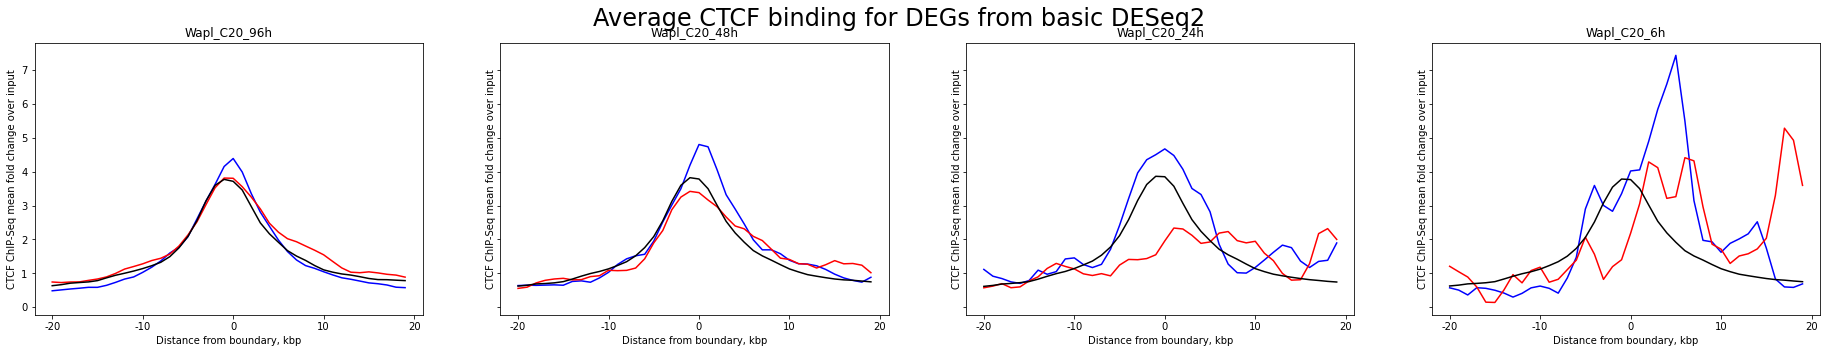

In [33]:
# Using Chip-Seq file for mm10 that was re-mapped 'RSC13_E14_CTCF_new.scale.bw'
DE_result_dict = basic_deseq_results
pval_cutoff = 0.05

deseq_degs_ctcf_binding(basic_deseq_results, 
                        "Average CTCF binding for DEGs from basic DESeq2",
                        pval_cutoff,
                        chip_seq_file)

==== General percentages for Condition : Wapl_C20_96h====
Setting qval cutoff to: 0.05
Number of DE transcripts with this cutoff: 3804
Number of DE transcripts with an annotated TSS: 3770
Number of up-regulated genes: 1745
Number of down-regulated genes: 2025

==== General percentages for Condition : Wapl_C20_48h====
Setting qval cutoff to: 0.05
Number of DE transcripts with this cutoff: 786
Number of DE transcripts with an annotated TSS: 778
Number of up-regulated genes: 312
Number of down-regulated genes: 466

==== General percentages for Condition : Wapl_C20_24h====
Setting qval cutoff to: 0.05
Number of DE transcripts with this cutoff: 158
Number of DE transcripts with an annotated TSS: 157
Number of up-regulated genes: 62
Number of down-regulated genes: 95

==== General percentages for Condition : Wapl_C20_6h====
Setting qval cutoff to: 0.05
Number of DE transcripts with this cutoff: 30
Number of DE transcripts with an annotated TSS: 30
Number of up-regulated genes: 11
Number of d

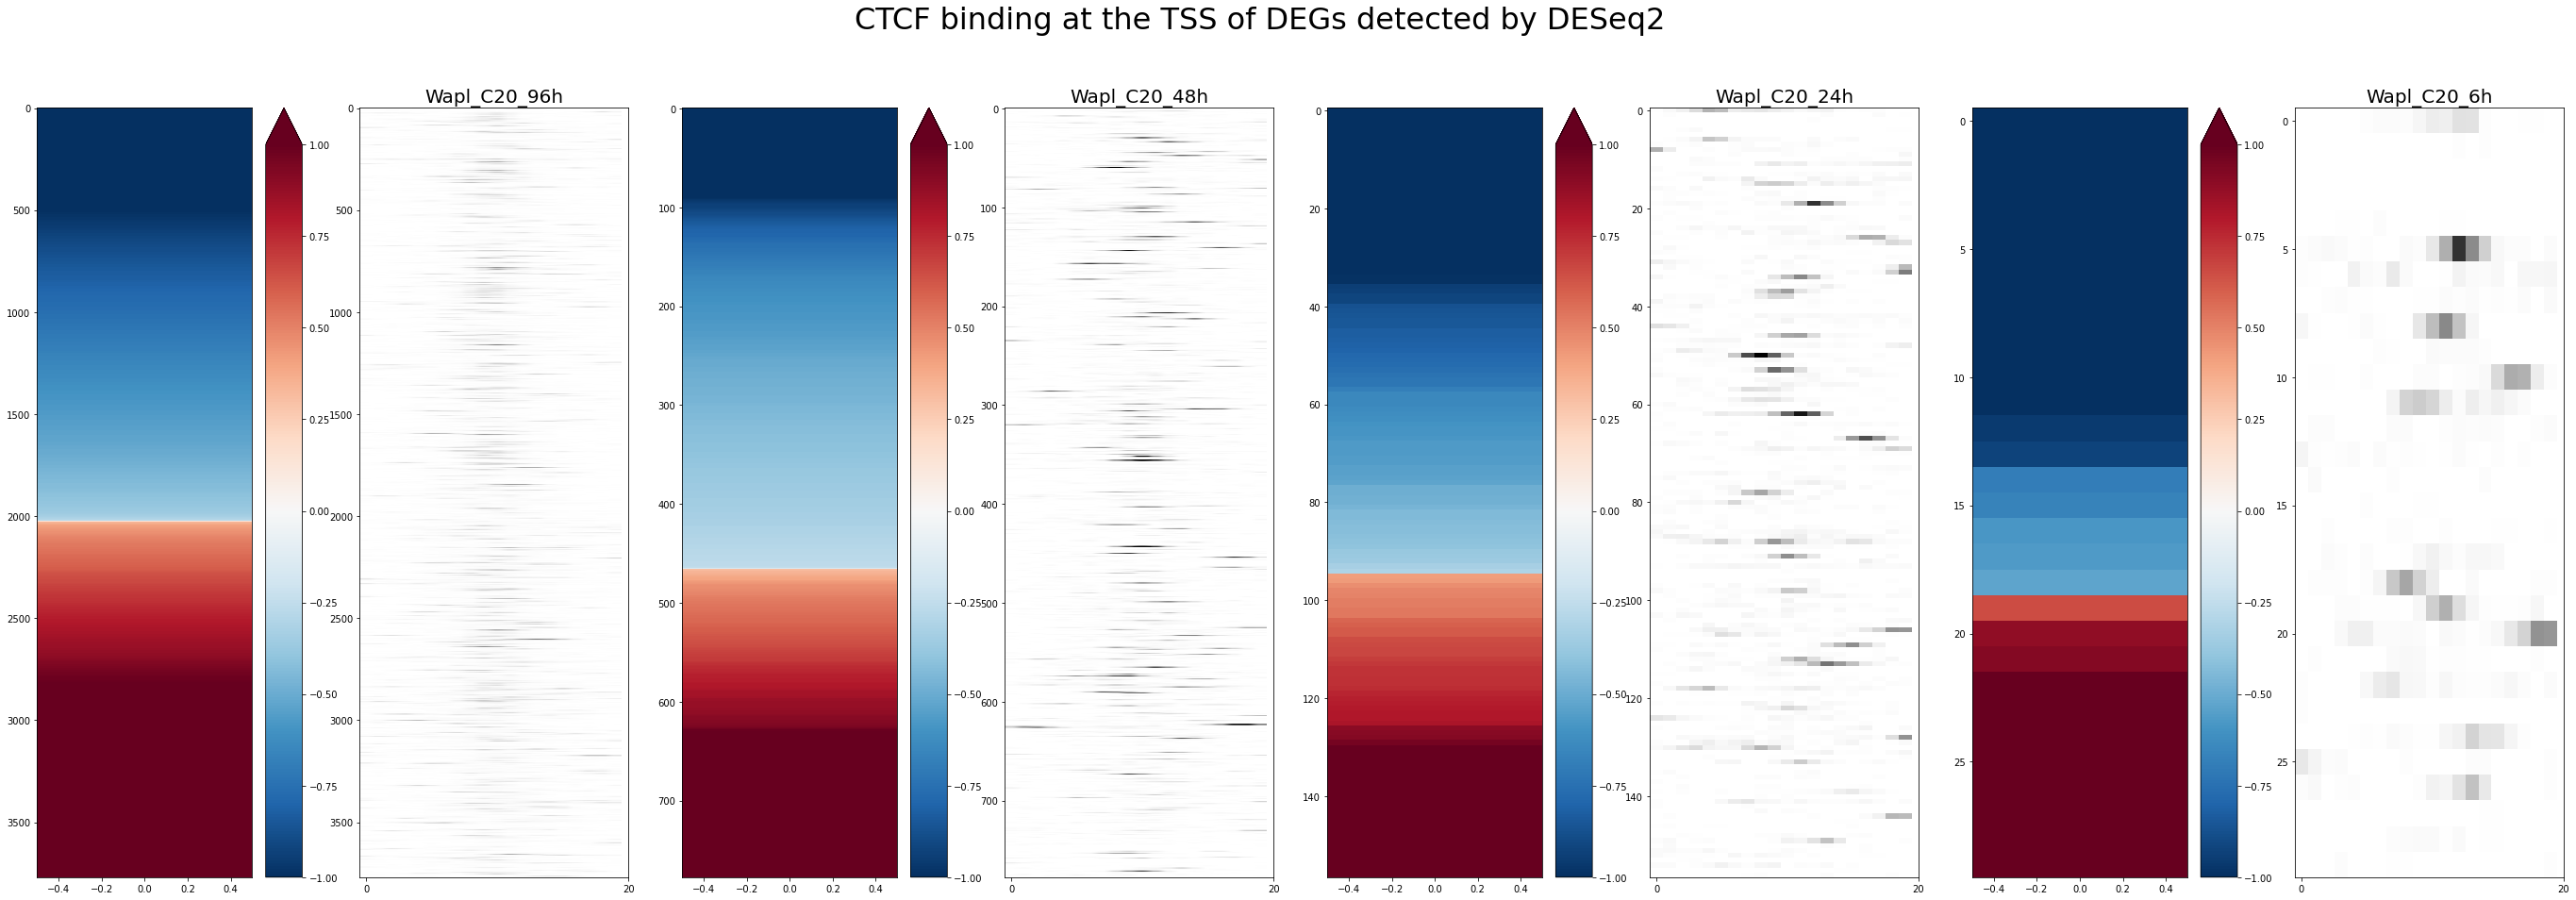

In [35]:
plot_deseq_CTCF_binding_together(basic_deseq_results,
                                 tss_df,
                                 chip_seq_file,
                                 pval_cutoff,
                                 "CTCF binding at the TSS of DEGs detected by DESeq2")

==== General percentages for Condition : Wapl_C20_96h====
Setting qval cutoff to: 0.05
Number of DE transcripts with this cutoff: 3804
Number of DE transcripts with an annotated TSS: 3770
Number of up-regulated genes: 1745
Number of down-regulated genes: 2025

==== General percentages for Condition : Wapl_C20_48h====
Setting qval cutoff to: 0.05
Number of DE transcripts with this cutoff: 786
Number of DE transcripts with an annotated TSS: 778
Number of up-regulated genes: 312
Number of down-regulated genes: 466

==== General percentages for Condition : Wapl_C20_24h====
Setting qval cutoff to: 0.05
Number of DE transcripts with this cutoff: 158
Number of DE transcripts with an annotated TSS: 157
Number of up-regulated genes: 62
Number of down-regulated genes: 95

==== General percentages for Condition : Wapl_C20_6h====
Setting qval cutoff to: 0.05
Number of DE transcripts with this cutoff: 30
Number of DE transcripts with an annotated TSS: 30
Number of up-regulated genes: 11
Number of d

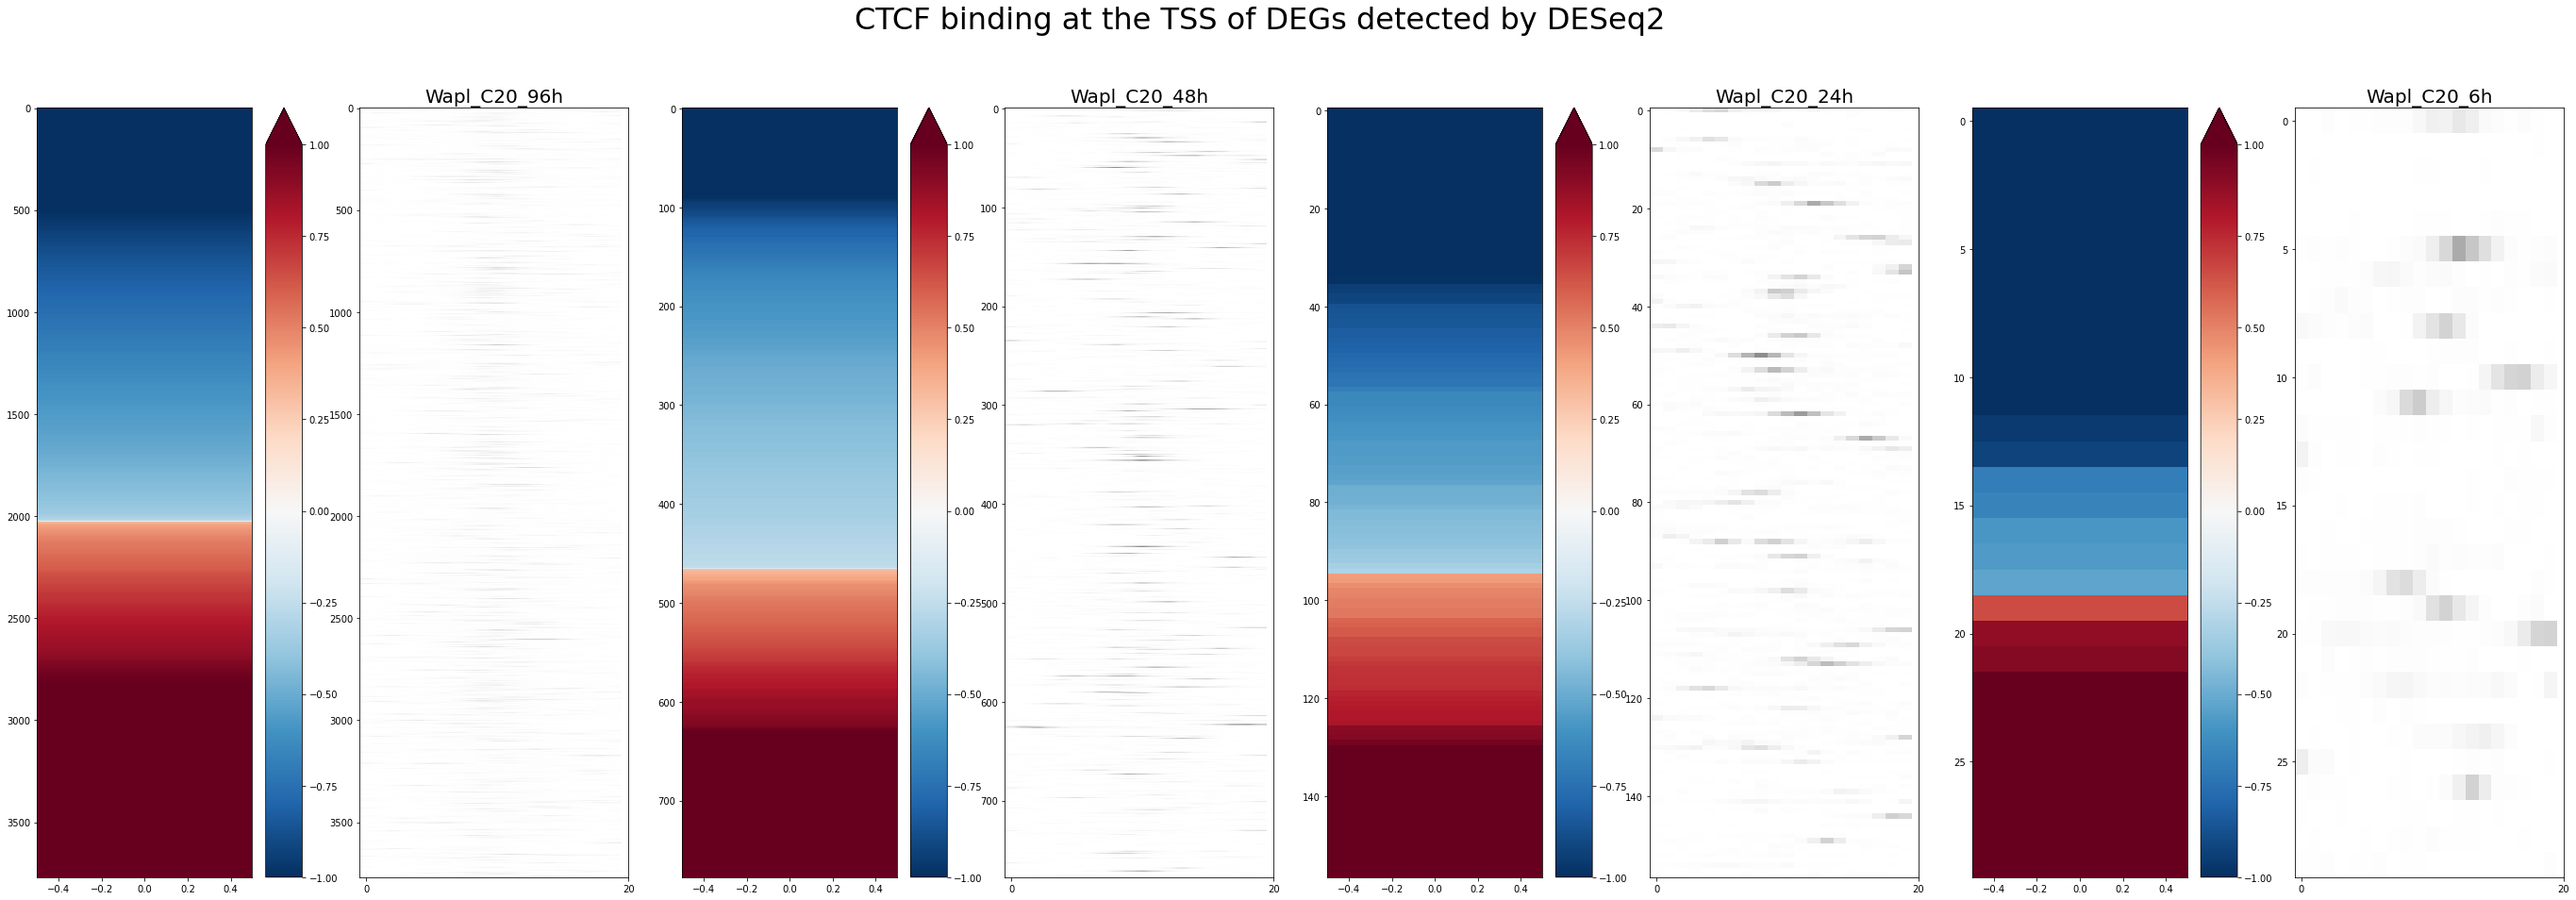

In [39]:
# Using another ChiP-seq file
chip_seq_file_RSC22 = "/project/fudenber_735/collaborations/karissa_2022/RNAseq/features/mm10/E14_CTCF/RSC22_E14_CTCF.scale.bw"

plot_deseq_CTCF_binding_together(basic_deseq_results, 
                                 tss_df,
                                 chip_seq_file_RSC22,
                                 pval_cutoff,
                                 "CTCF binding at the TSS of DEGs detected by DESeq2")

Signal is even lower than RSC13 -- will ditch this one

==== General percentages for Condition : Wapl_C20_96h====
Setting qval cutoff to: 0.05
Number of DE transcripts with this cutoff: 3804
Number of DE transcripts with an annotated TSS: 3770
Number of up-regulated genes: 1745
Number of down-regulated genes: 2025

==== General percentages for Condition : Wapl_C20_48h====
Setting qval cutoff to: 0.05
Number of DE transcripts with this cutoff: 786
Number of DE transcripts with an annotated TSS: 778
Number of up-regulated genes: 312
Number of down-regulated genes: 466

==== General percentages for Condition : Wapl_C20_24h====
Setting qval cutoff to: 0.05
Number of DE transcripts with this cutoff: 158
Number of DE transcripts with an annotated TSS: 157
Number of up-regulated genes: 62
Number of down-regulated genes: 95

==== General percentages for Condition : Wapl_C20_6h====
Setting qval cutoff to: 0.05
Number of DE transcripts with this cutoff: 30
Number of DE transcripts with an annotated TSS: 30
Number of up-regulated genes: 11
Number of d

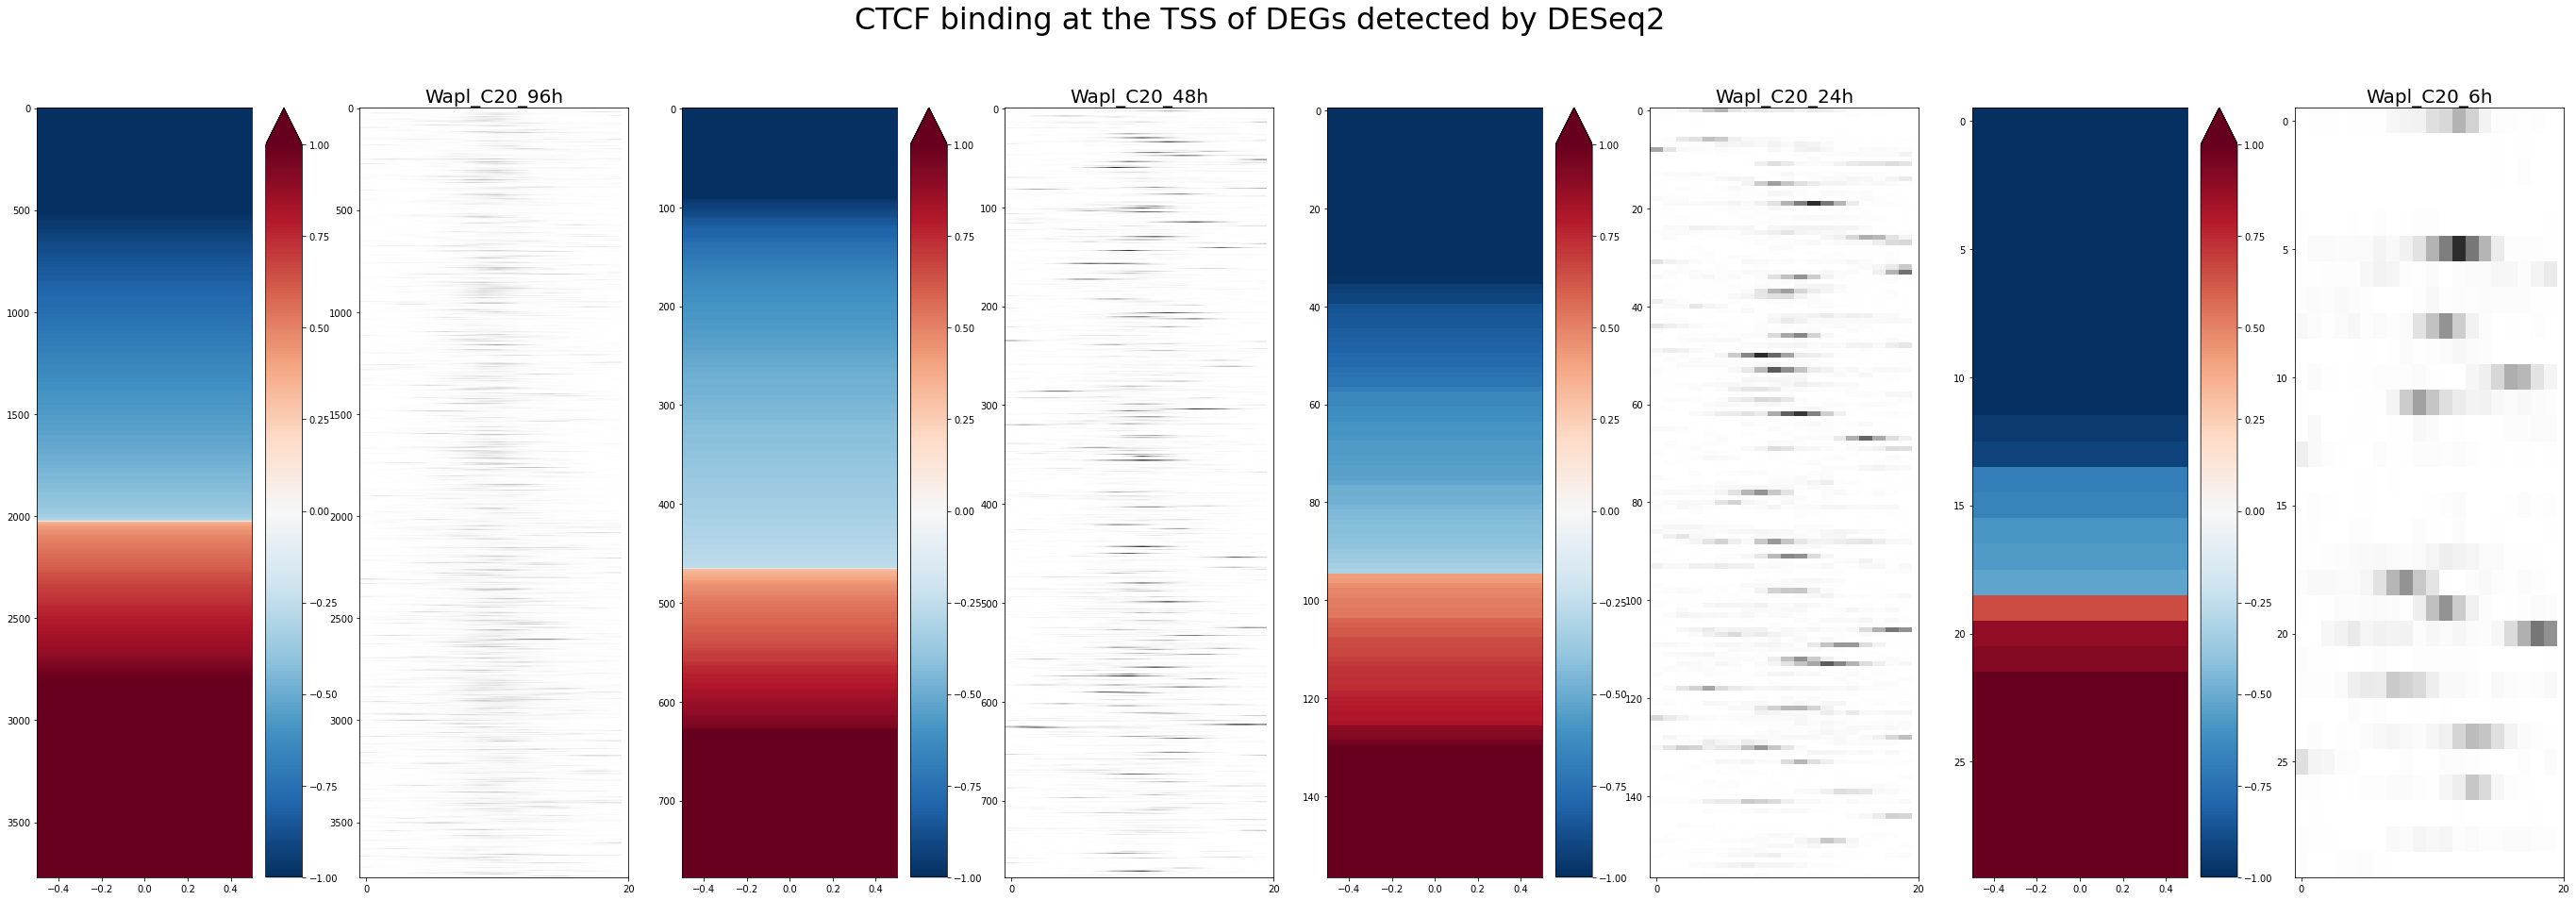

In [38]:
# Using yet another ChiP-seq file -- not sure we got an explanation of this one
chip_seq_file_RSC22 = "/project/fudenber_735/collaborations/karissa_2022/RNAseq/features/mm10/E14_CTCF/RSC37_E14_CTCF.scale.bw"

plot_deseq_CTCF_binding_together(basic_deseq_results, 
                                 tss_df,
                                 chip_seq_file_RSC22,
                                 pval_cutoff,
                                 "CTCF binding at the TSS of DEGs detected by DESeq2")

Looks the same at RSC13. Seems like RSC13 is the best, so I'll continue with that one until we either get a merged signal version or maybe liftover from mm9?

### Notes/Observations


```
"I had resequenced RSC12 and RSC13 to get more reads. Got good number of reads for RSC12 (which is Rad21 ChIP). RSC13 (CTCF ChIP) is also good but still fewer reads than I was aiming for. And hence these samples which were sequenced again are called new_scale (edited).
I need to merge my previous and the new RSC13 fastq files so that overall there are more reads when combined together and remap. Nevertheless, the ChIP quality is decent. Will be doing the merge and remap it soon and share.
Have generated the bw files for the input. Will just view them on the browser once and share." 
```

## ChiP-Seq file from Justice_2020:

Just to compare to another version that showed stronger signal when recapitulating dCTCF results (see TSS_heatmaps_mm10.ipynb)

==== General percentages for Condition : Wapl_C20_96h====
Setting qval cutoff to: 0.05
Number of DE transcripts with this cutoff: 3804
Number of DE transcripts with an annotated TSS: 3770
Number of up-regulated genes: 1745
Number of down-regulated genes: 2025

==== General percentages for Condition : Wapl_C20_48h====
Setting qval cutoff to: 0.05
Number of DE transcripts with this cutoff: 786
Number of DE transcripts with an annotated TSS: 778
Number of up-regulated genes: 312
Number of down-regulated genes: 466

==== General percentages for Condition : Wapl_C20_24h====
Setting qval cutoff to: 0.05
Number of DE transcripts with this cutoff: 158
Number of DE transcripts with an annotated TSS: 157
Number of up-regulated genes: 62
Number of down-regulated genes: 95

==== General percentages for Condition : Wapl_C20_6h====
Setting qval cutoff to: 0.05
Number of DE transcripts with this cutoff: 30
Number of DE transcripts with an annotated TSS: 30
Number of up-regulated genes: 11
Number of d

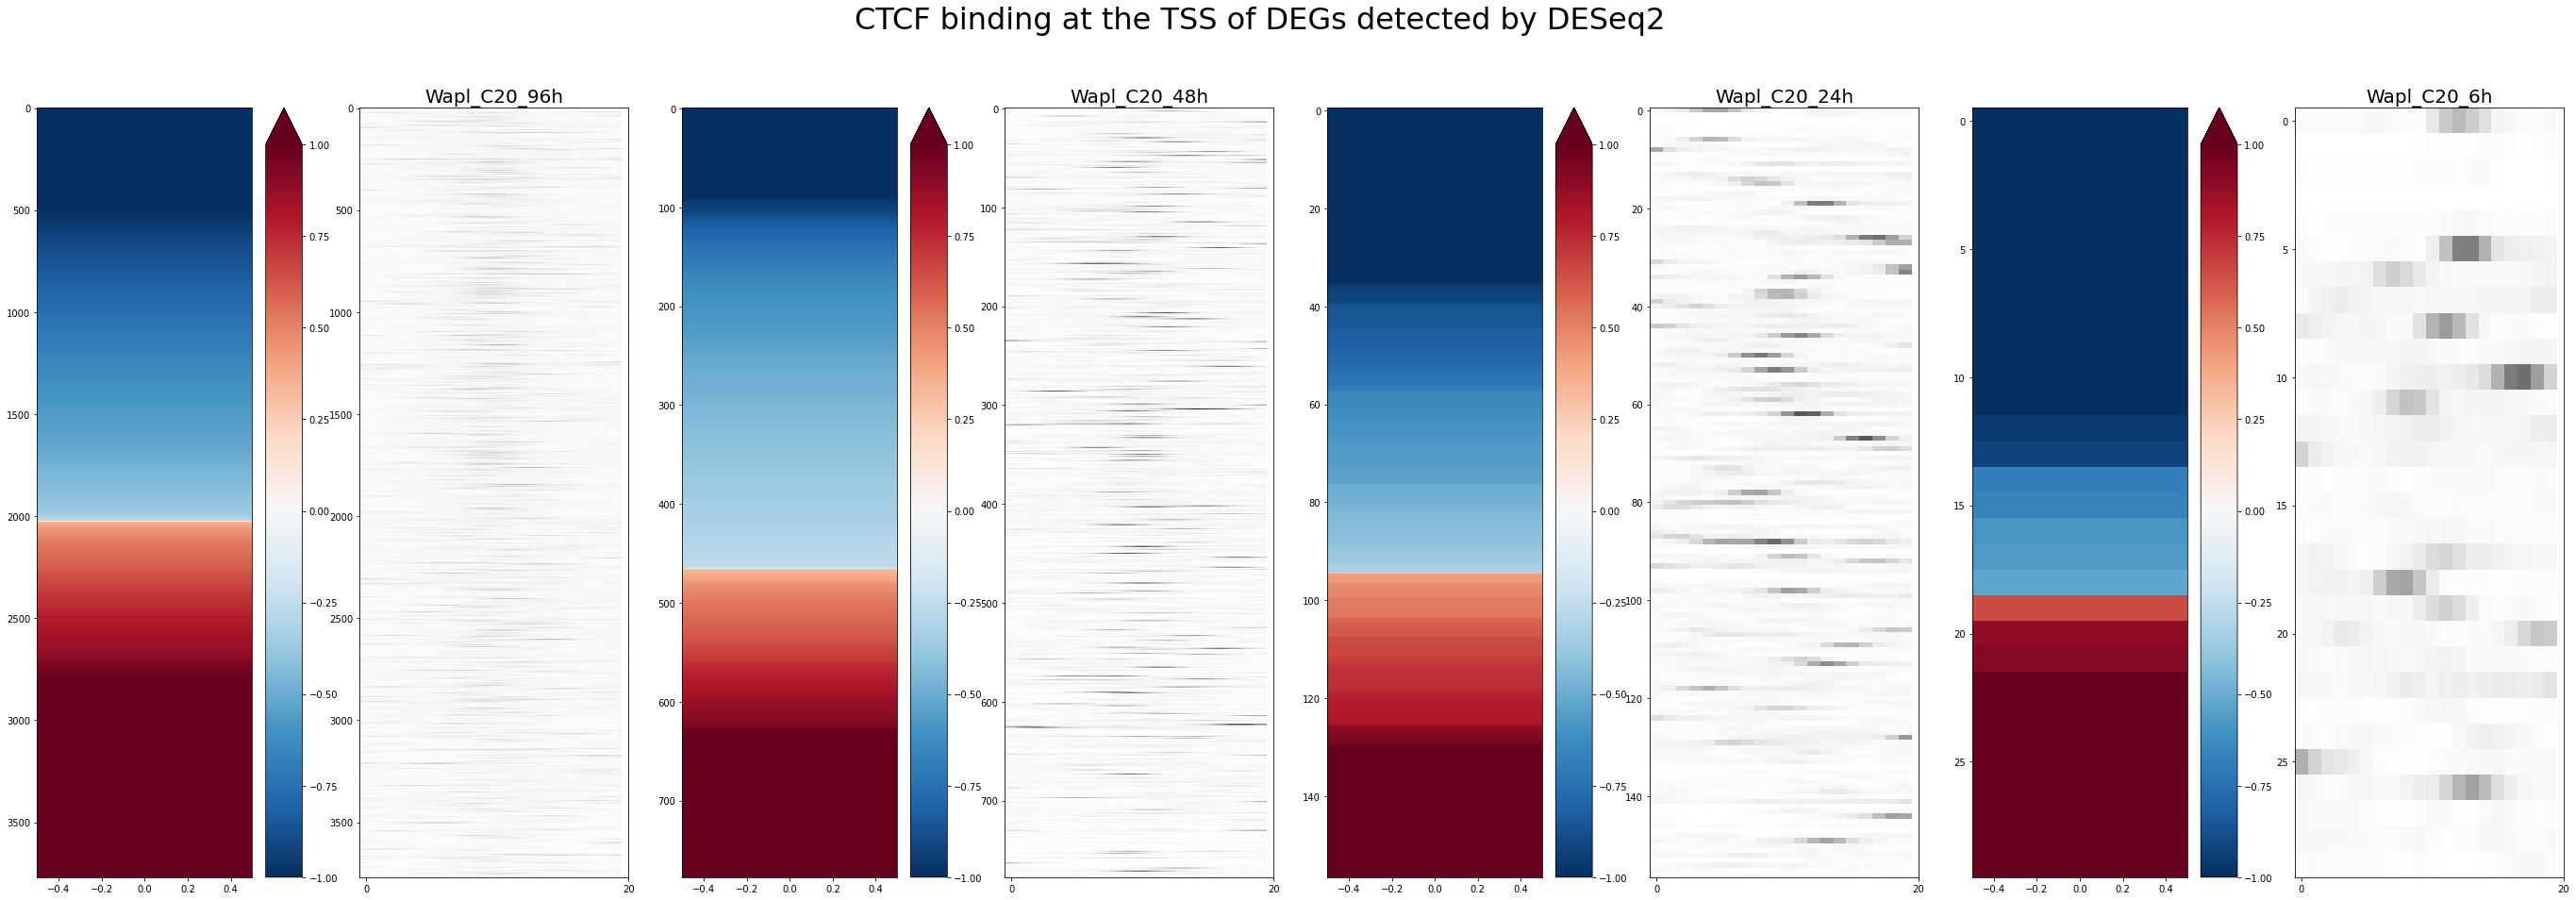

In [40]:
chip_seq_file_justice = "/project/fudenber_735/GEO/justice_2020_GSE137272/mm10/GSE137272_CTCF-ChIPseq.bw"

plot_deseq_CTCF_binding_together(basic_deseq_results, 
                                 tss_df,
                                 chip_seq_file_justice,
                                 pval_cutoff,
                                 "CTCF binding at the TSS of DEGs detected by DESeq2")

# CTCF Binding at TSS of DEGs following depletion of Nipbl
/project/fudenber_735/collaborations/karissa_2022/RNAseq-mapped/DE-results/pairwise_deseq_wt_dTAG_13_24h_vs_DMSO_24h.csv

In [47]:
# data needed from experimental set-up to compare 

# s2c to collapse tpm into averages
s2c = pd.read_csv("/project/fudenber_735/collaborations/karissa_2022/RNAseq-mapped/s2c_DMSO_24h_vs_dTAG_13_24h.csv", index_col = 0)

# t2g to compare gene-level analysis
t2g = pd.read_csv("/project/fudenber_735/genomes/mm10/ensembl/ensembl_relational_downloads/biomaRt_mm10_t2g.csv", index_col = 0)

In [49]:
s2c

,sample,condition
1,KHRNA22,DMSO_24h
2,KHRNA23,DMSO_24h
3,KHRNA50,DMSO_24h
4,KHRNA25,dTAG_13_24h
5,KHRNA26,dTAG_13_24h
6,KHRNA51,dTAG_13_24h


In [50]:
conditions = s2c['condition'].unique()
conditions = [x.strip() for x in conditions]

conditions

['DMSO_24h', 'dTAG_13_24h']

In [52]:
# import DEseq results

# Importing the .csv outputs from sleuth WT for each of the conditions into pandas dataframes:
nipbl_deseq_results = {}

# Only have one set from this example, but still save in a dict for standardization --> some functions expect it to be this way
dNipbl_res = pd.read_csv('/project/fudenber_735/collaborations/karissa_2022/RNAseq-mapped/DE-results/pairwise_deseq_wt_dTAG_13_24h_vs_DMSO_24h.csv')
nipbl_deseq_results['dTAG_13_24h'] = dNipbl_res

In [65]:
nipbl_deseq_results['dTAG_13_24h'] = nipbl_deseq_results['dTAG_13_24h'].rename(columns={"Unnamed: 0" : "gene_id"})

In [89]:
#add TSSes
nipbl_deseq_results['dTAG_13_24h'] = nipbl_deseq_results['dTAG_13_24h'].merge(tss_df.drop_duplicates(['gene_id']), how='left', on='gene_id', suffixes=("_DEG", "_TSS"))

#DE_results_TSS = DE_result_df.merge(tss_df.drop_duplicates(['gene_id']), how='left', on='gene_id', suffixes=("_DEG", "_TSS"))

Out of 111033 transcripts from the sleuth output results, 110170 had corresponding TSS from ensembl GTF files.
Lost 863 transcripts for this analysis.


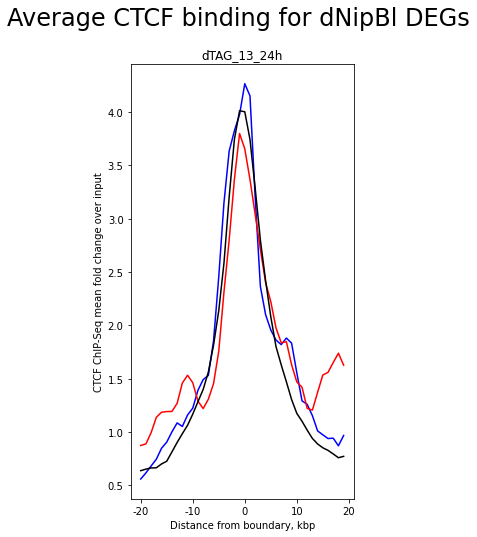

In [130]:
deseq_degs_ctcf_binding(nipbl_deseq_results, 
                        "Average CTCF binding for dNipBl DEGs",
                        pval_cutoff,
                        chip_seq_file)

Noticing the scale here... There seems to be pretty minimal CTCF binding at the TSS of DEGs due to dNipbl compared to dCTCF DEGs.

==== General percentages for Condition : dTAG_13_24h====
Setting qval cutoff to: 0.05
Number of DE transcripts with this cutoff: 5973
Number of DE transcripts with an annotated TSS: 5968
Number of up-regulated genes: 3272
Number of down-regulated genes: 2696



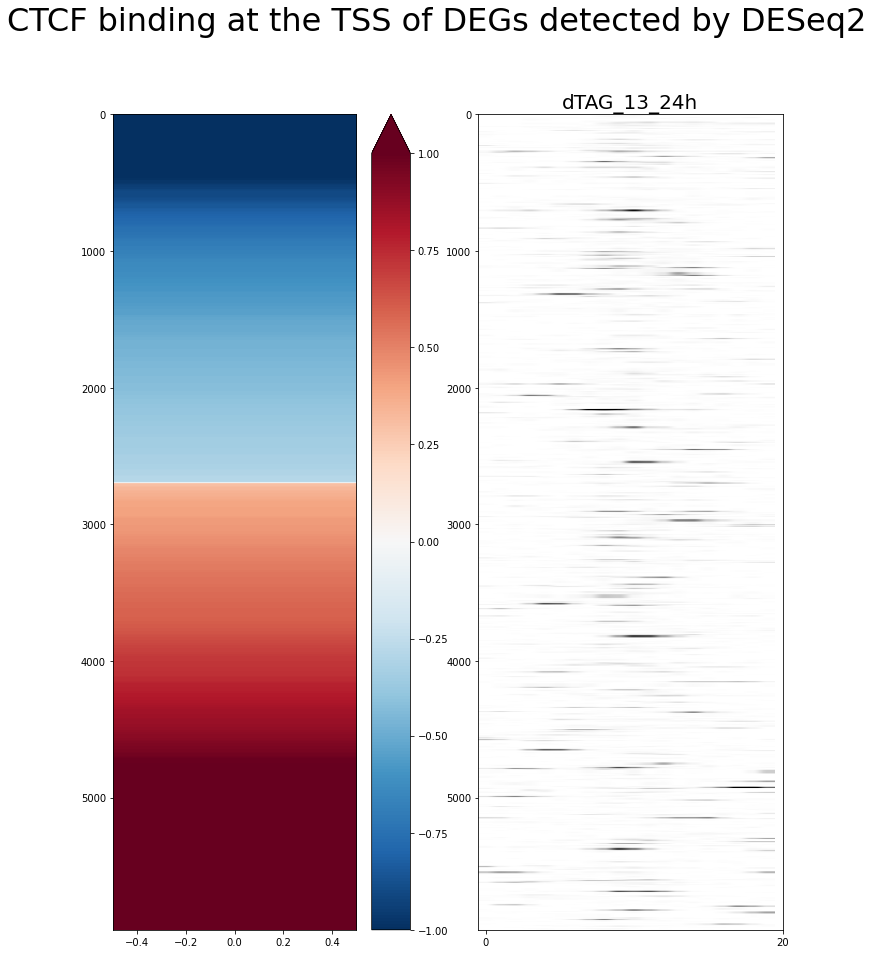

In [128]:
plot_deseq_CTCF_binding_together(nipbl_deseq_results, 
                                 tss_df,
                                 chip_seq_file,
                                 pval_cutoff,
                                 "CTCF binding at the TSS of DEGs detected by DESeq2")

# Graphing functions: (essentially taken from TSS_headmaps_deseq.ipynb)

In [28]:
## To average CTCF signal for up-regulated vs down-regulated genes
def deseq_degs_ctcf_binding(DE_result_dict, figure_title, pval_cutoff, chip_seq_file):

    # Getting plots ready
    num_plots = len(DE_result_dict)
    fig, ax = plt.subplots(1, num_plots, sharey=True, figsize=(8*num_plots, 5))
    fig.suptitle(figure_title, fontsize=24)
    i = 0

    for condition, DE_result_df in DE_result_dict.items():

        
        # # lookup the TSS for this set of transcripts -- when result table not indexed by gene id
        # DE_results_TSS = DE_result_df.merge(tss_df.drop_duplicates(['gene_id']), how='inner', on='gene_id', suffixes=("_DEG", "_TSS"))
        
        # lookup TSS for this set of transcripts
        DE_results_TSS = DE_result_df.merge(tss_df.drop_duplicates(['gene_id']), left_index=True, right_on='gene_id')
        

        # how many did not have a transcript/were dropped?
        ni = len(DE_result_df)
        ntss = len(DE_results_TSS)
        print("Out of " + str(ni) + " transcripts from the sleuth output results, " + str(ntss) + " had corresponding TSS from ensembl GTF files.")
        print("Lost " + str(ni-ntss) + " transcripts for this analysis.")

        # Extracting significantly DE transcripts
        sig_DE = DE_results_TSS[DE_results_TSS['padj'] < pval_cutoff]
        sig_DE_up = sig_DE[sig_DE['log2FoldChange'] > 0]
        sig_DE_down = sig_DE[sig_DE['log2FoldChange'] <= 0]

        # Will also look at enrichment around transcripts that were in RNAseq dataset that did not have significant DE
        nonsig_DE = DE_results_TSS[DE_results_TSS['padj'] >= pval_cutoff]

        nbins = 40

        # initializing variables for pybbi matrices
        DE_up_matrix = None
        DE_down_matrix = None

        # Generating summary of chip seq signal within the bins -1000 and +1000 from the TSS loc
        with bbi.open(chip_seq_file) as f:
            if not sig_DE_up.empty:
                DE_up_matrix = f.stackup(sig_DE_up['chrom'], sig_DE_up['start'] - 1000, sig_DE_up['end'] + 1000, bins=nbins)
            if not sig_DE_down.empty:
                DE_down_matrix = f.stackup(sig_DE_down['chrom'], sig_DE_down['start'] - 1000, sig_DE_down['end'] + 1000, bins=nbins)
            nonsig_DE_matrix = f.stackup(nonsig_DE['chrom'], nonsig_DE['start'] - 1000, nonsig_DE['end'] + 1000, bins=nbins)



        if (len(fig.axes) == 1):
            this_ax = ax
        else:
            this_ax = ax[i]
            
        if DE_down_matrix is not None:
            this_ax.plot(np.nanmean(DE_down_matrix, axis=0), color = 'b' )

        if DE_up_matrix is not None:
            this_ax.plot(np.nanmean(DE_up_matrix, axis=0), color = 'r' )

        this_ax.plot(np.nanmean(nonsig_DE_matrix, axis=0), color = 'k')

        this_ax.set(xticks=np.arange(0, nbins+1, 10),
               xticklabels=(np.arange(0, nbins+1, 10)-nbins//2),
               xlabel='Distance from boundary, kbp',
               ylabel='CTCF ChIP-Seq mean fold change over input')
        this_ax.set_title(condition)

        i+=1


In [ ]:
plt.savefig("avg_ctcf_binding_deseq")

In [ ]:
plt.savefig("avg_ctcf_binding_deseq_batch")

In [29]:
## For plotting the log change in FPKM, as a measure of differential expression, alongside the binding of 
## that transcript at it's TSS.
# 
# cutoff: the deltaFPKM to take
# DE_df: must have the columns 'delta' for the FPKM, must be in sorted order by delta
# CTCF ChIP-exo filepath
def plot_deseq_CTCF_binding_together(DE_result_dict, tss_df, chip_seq_file, qval_cutoff, plot_title):
    
    
    # Getting plots ready
    num_conditions = len(DE_result_dict)
    fig, ax = plt.subplots(1,2*num_conditions, figsize=(12*num_conditions, 15))
    fig.suptitle(plot_title, fontsize=32)
    i = 0
    
    for condition, DE_result_df in DE_result_dict.items():

        # Extracting only rows that are above the cutoff
        sig_DE = DE_result_df[DE_result_df['padj'] < qval_cutoff]

        sig_DE = sig_DE.sort_values(by=['log2FoldChange'])

        n_DE_tot = len(sig_DE)

        # # lookup the TSS for this set of transcripts
        # window_df = sig_DE.merge(tss_df.drop_duplicates(['gene_id']), how='inner', on='gene_id', suffixes=("_DEG", "_TSS"))
        
        # lookup the TSS for this set of transcripts -->version where results indexed by gene_id
        window_df = sig_DE.merge(tss_df.drop_duplicates(['gene_id']), left_index=True, right_on='gene_id')
        

        # Generating summary of chip seq signal within the bins -1000 and +1000 from the TSS loc
        with bbi.open(chip_seq_file) as f:
            #DE_matrix = f.stackup(window_df['chrom_TSS'], window_df['start_TSS'] - 1000, window_df['end_TSS'] + 1000, bins=20)
            
            DE_matrix = f.stackup(window_df['chrom'], window_df['start'] - 1000, window_df['end'] + 1000, bins=20)


        # split by positive and negative values for plotting
        DE_up = window_df[window_df['log2FoldChange'] > 0]
        DE_down = window_df[window_df['log2FoldChange'] < 0]

        n = len(window_df)
        n_up = len(DE_up)
        n_down = len(DE_down)

        print("==== General percentages for Condition : " + condition + "====")
        print("Setting qval cutoff to: " + str(qval_cutoff))
        print("Number of DE transcripts with this cutoff: " + str(n_DE_tot))
        print("Number of DE transcripts with an annotated TSS: " + str(n))
        print("Number of up-regulated genes: " + str(n_up))
        print("Number of down-regulated genes: " + str(n_down))
        print()


        # extracting the beta change vector
        logFPKM = window_df['log2FoldChange']
        logFPKM = np.transpose(np.expand_dims(logFPKM, axis=0))
        minval=np.min(logFPKM)
        maxval=np.max(logFPKM)
        # if diverging, color negative values blue
        if (minval < 0):
            divnorm=colors.TwoSlopeNorm(vmin=-1, vcenter=0., vmax=1)
            hotcoldmap = plt.cm.get_cmap('RdBu').reversed()
            occ = ax[i].imshow(logFPKM, cmap=hotcoldmap, norm=divnorm, aspect='auto')
        # pcolormesh(your_data, cmap="coolwarm", norm=divnorm)
        else:
            minval= 0
            occ = ax[i].imshow(logFPKM, cmap='Reds', norm=colors.Normalize(vmin=0, vmax=1), aspect='auto')


        cbar = ax[i].figure.colorbar(occ, ax=ax[i], extend='max')
        i+=1
        name = condition
        ax[i].set_title(name, fontsize=20)
        # Plotting ctcf binding
        fig = ax[i].imshow(DE_matrix, cmap='gray_r', aspect='auto', vmin=0, vmax=100)
        ax[i].set_xticks([0, 20])
        i+=1

    plt.show()

In [45]:
up_deseq = {}
down_deseq = {}
up_batch_deseq = {}
down_batch_deseq = {}
qval_cutoff = 0.05

for cond, DE_results in deseq_results.items():

    sig_DE = DE_results[DE_results['padj'] < qval_cutoff]
    sig_DE_up = sig_DE[sig_DE['log2FoldChange'] > 0]
    sig_DE_down = sig_DE[sig_DE['log2FoldChange'] <= 0]
    
    up_deseq[cond] = len(sig_DE_up)
    down_deseq[cond] = len(sig_DE_down)
    
for cond, DE_results in deseq_batch_results.items():
    
    sig_DE = DE_results[DE_results['padj'] < qval_cutoff]
    sig_DE_up = sig_DE[sig_DE['log2FoldChange'] > 0]
    sig_DE_down = sig_DE[sig_DE['log2FoldChange'] <= 0]
    
    up_batch_deseq[cond] = len(sig_DE_up)
    down_batch_deseq[cond] = len(sig_DE_down)
    


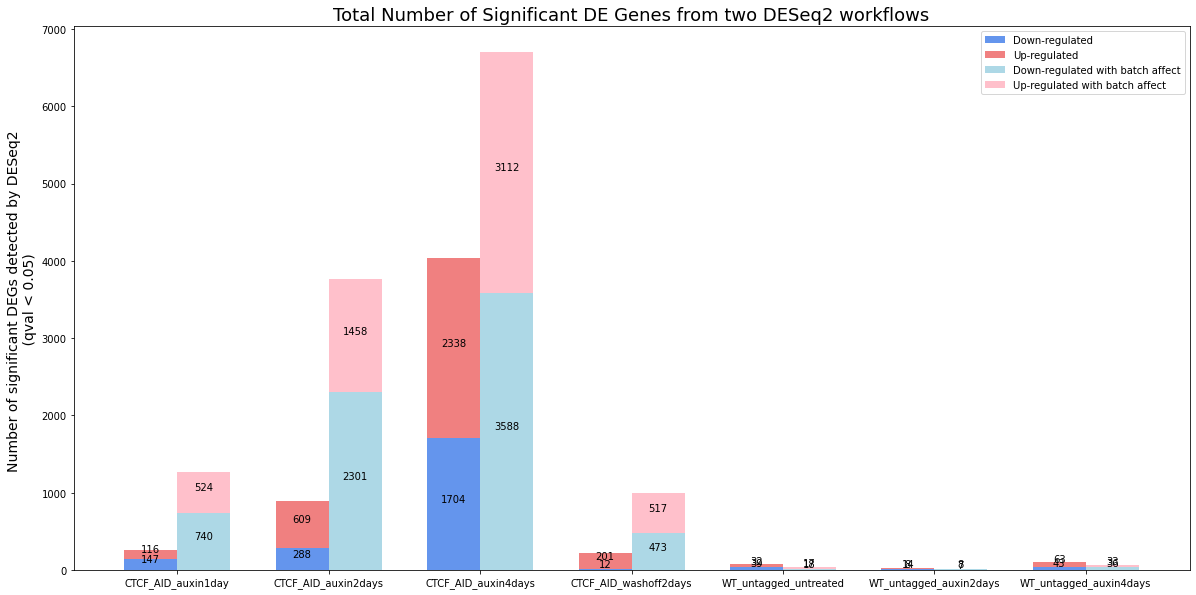

In [46]:
width = 0.35

fig, ax = plt.subplots(figsize=[20,10])

downbars = ax.bar(down_deseq.keys(), list(down_deseq.values()), -width, align='edge', label = "Down-regulated", color='cornflowerblue')
upbars = ax.bar(up_deseq.keys(), list(up_deseq.values()), -width, align='edge', bottom = list(down_deseq.values()), label = "Up-regulated", color='lightcoral')

downbars2 = ax.bar(down_batch_deseq.keys(), list(down_batch_deseq.values()), +width, align='edge', label = "Down-regulated with batch affect", color='lightblue')
upbars2 = ax.bar(up_batch_deseq.keys(), list(up_batch_deseq.values()), +width, align='edge', bottom = list(down_batch_deseq.values()), label = "Up-regulated with batch affect", color='pink')

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        b = rect.get_y()
        plt.text(rect.get_x() + rect.get_width()/2., .5*(height)+b,
                '%d' % int(height),
                ha='center', va='bottom')


plt.ylabel("Number of significant DEGs detected by DESeq2 \n (qval < 0.05) ", size=14)
plt.title("Total Number of Significant DE Genes from two DESeq2 workflows", size=18)
plt.legend()

autolabel(upbars)
autolabel(upbars2)
autolabel(downbars)
autolabel(downbars2)

plt.show()